In [1]:
try:
    from mumott.data_handling import DataContainer
except:
    !sh ../scripts/setup.sh

INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


In [2]:
import sys
sys.path.insert(0, '/myhome/smartt')
sys.path.insert(0, '/das/home/barbaf_l/smartTT')

# Core imports
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
from pathlib import Path

# mumott imports
from mumott.data_handling import DataContainer
from mumott.methods.basis_sets import SphericalHarmonics
from mumott.methods.projectors import SAXSProjectorCUDA as SAXSProjector  # CPU version only
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.optimizers import LBFGS
from mumott.optimization.regularizers import Laplacian

# Our PyTorch implementation
from smartt.projectors import forward_project, backproject, build_mumott_projector
from smartt.shutils.evaulate_sh import forward_quadrature
import lovely_tensors as lt
lt.monkey_patch()

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/cupy/_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


Imports successful!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: Tesla T4


In [3]:
# Configuration
# DATA_PATH = "/myhome/data/smartt/shared/frogbone/dataset_qbin_0009.h5"
DATA_PATH = '/das/home/barbaf_l/p20639/Mads/frog/frogbone/dataset_qbin_0009.h5'
ELL_MAX = 8
NUM_PROJECTIONS = 10  # Use smaller subset to avoid memory issues
SEED = 42

# Set random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print(f"Configuration:")
print(f"  Data path: {DATA_PATH}")
print(f"  ell_max: {ELL_MAX}")
print(f"  Number of projections: {NUM_PROJECTIONS}")
print(f"  Random seed: {SEED}")

Configuration:
  Data path: /das/home/barbaf_l/p20639/Mads/frog/frogbone/dataset_qbin_0009.h5
  ell_max: 8
  Number of projections: 10
  Random seed: 42


In [4]:
# Load data
print(f"Loading data from {DATA_PATH}...")
dc = DataContainer(DATA_PATH, nonfinite_replacement_value=0)

print(f"\nOriginal dataset:")
print(f"  Total projections: {len(dc.projections)}")
print(f"  Volume shape: {dc.geometry.volume_shape}")
print(f"  Projection shape: {dc.geometry.projection_shape}")
print(f"  Detector segments: {dc.geometry.probed_coordinates.vector.shape[0]}")

# Select subset of projections for testing
total_projections = len(dc.projections)
if NUM_PROJECTIONS < total_projections:
    # Uniformly sample projections
    indices_to_keep = set(np.linspace(0, total_projections - 1, NUM_PROJECTIONS, dtype=int))
    indices_to_delete = [i for i in range(total_projections) if i not in indices_to_keep]
    # Delete in reverse order to preserve indices
    for i in sorted(indices_to_delete, reverse=True):
        del dc.projections[i]
    print(f"\nReduced to {len(dc.projections)} projections")

# Store reference to geometry
geometry = dc.geometry
volume_shape = tuple(geometry.volume_shape)
num_coeffs = (ELL_MAX // 2 + 1) * (ELL_MAX + 1)

print(f"\nTest dataset summary:")
print(f"  Projections: {len(dc.projections)}")
print(f"  Volume shape: {volume_shape}")
print(f"  SH coefficients: {num_coeffs}")

Loading data from /das/home/barbaf_l/p20639/Mads/frog/frogbone/dataset_qbin_0009.h5...
INFO:Rotation matrices were loaded from the input file.


/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/data_container.py:227: DeprecationWarning: Entry name rotations is deprecated. Use inner_angle instead.
  _deprecated_key_warning('rotations')
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/data_container.py:236: DeprecationWarning: Entry name tilts is deprecated. Use outer_angle instead.
  _deprecated_key_warning('tilts')
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/data_container.py:246: DeprecationWarning: Entry name rot_mat is deprecated. Use rotation_matrix instead.
  _deprecated_key_warning('rot_mat')
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/data_container.py:268: DeprecationWarning: Entry name offset_j is deprecated. Use j_offset instead.
  _deprecated_key_warning('offset_j')
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/mumott/data_handling/d

INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.

Original dataset:
  Total projections: 240
  Volume shape: [65 82 65]
  Projection shape: [ 73 100]
  Detector segments: 240

Reduced to 10 projections

Test dataset summary:
  Projections: 10
  Volume shape: (65, 82, 65)
  SH coefficients: 45


## 1. Loss Function Equivalence Test

First, let's verify that both implementations compute the same forward pass and loss for identical inputs.

In [5]:
import torch
import h5py
# Load saved results from HDF5
load_results = True  # Set to True to load
# input_path = '/myhome/smartt/results/sparse_uncertainty_analysis.h5'
input_path = '/das/home/barbaf_l/p20639/Luis/sparse_uncertainty_analysis.h5'

if load_results:
    print(f"Loading results from {input_path}...")
    
    with h5py.File(input_path, 'r') as f:
        # Load reconstructions
        all_reconstructions = f['all_reconstructions'][:]
        mean_reconstruction = f['mean_reconstruction'][:]
        std_reconstruction = f['std_reconstruction'][:]
        ground_truth = f['ground_truth'][:]
        
        # Load indices
        fixed_sparse_indices = f['fixed_sparse_indices'][:]
        subsample_indices_list = []
        for i in range(f.attrs['num_experiments']):
            subsample_indices = f[f'subsample_indices_{i}'][:]
            subsample_indices_list.append(subsample_indices)
        
        # Load metadata
        ell_max = f.attrs['ell_max']
        num_experiments = f.attrs['num_experiments']
        num_projections_sparse = f.attrs['num_projections_sparse']
        num_subsamples = f.attrs['num_subsamples']
        total_projections = f.attrs['total_projections']
        volume_shape = tuple(f.attrs['volume_shape'])
        num_coeffs = f.attrs['num_coeffs']
        seed = f.attrs['seed']
    
    print(f"Results loaded successfully!")
    print(f"\nLoaded data:")
    print(f"  all_reconstructions shape: {all_reconstructions.shape}")
    print(f"  mean_reconstruction shape: {mean_reconstruction.shape}")
    print(f"  std_reconstruction shape: {std_reconstruction.shape}")
    print(f"  ground_truth shape: {ground_truth.shape}")
    print(f"  Number of experiments: {num_experiments}")
    print(f"  Fixed sparse subset: {len(fixed_sparse_indices)} projections")
    print(f"  Subsample size: {num_subsamples} projections")
else:
    print("Results not loaded (set load_results=True to load)")
    mean_reconstruction = torch.randn(65, 82, 65, 45).numpy()
    print("mean_reconstruction", mean_reconstruction.shape)

import torch
import lovely_tensors as lt
lt.monkey_patch()
test_volume_np = mean_reconstruction

test_volume_np_f32 = test_volume_np.astype(np.float32)
test_volume_torch = torch.tensor(test_volume_np_f32, device=device, dtype=torch.float32)

print(f"Test volume shape: {test_volume_np.shape}")
print(f"Test volume stats: min={test_volume_np.min():.4f}, max={test_volume_np.max():.4f}, mean={test_volume_np.mean():.4f}")


Loading results from /das/home/barbaf_l/p20639/Luis/sparse_uncertainty_analysis.h5...
Results loaded successfully!

Loaded data:
  all_reconstructions shape: (5, 65, 82, 65, 45)
  mean_reconstruction shape: (65, 82, 65, 45)
  std_reconstruction shape: (65, 82, 65, 45)
  ground_truth shape: (65, 82, 65, 45)
  Number of experiments: 5
  Fixed sparse subset: 60 projections
  Subsample size: 48 projections
Test volume shape: (65, 82, 65, 45)
Test volume stats: min=-1131.0168, max=1097.6969, mean=4.0316


In [6]:
test_volume_np = mean_reconstruction
# test_volume_np = pytorch_results['reconstruction'].numpy()
# test_volume_np = mumott_results['reconstruction'].numpy()

test_volume_np_f32 = test_volume_np.astype(np.float32)
test_volume_torch = torch.tensor(test_volume_np_f32, device=device, dtype=torch.float32)


In [7]:
# mumott forward pass
print("=" * 60)
print("Testing mumott forward pass")
print("=" * 60)

# Clear GPU memory first
torch.cuda.empty_cache()

# Create mumott projector - use CPU version to avoid GPU memory conflicts
mumott_projector = SAXSProjector(geometry)  # CPU version for stability
mumott_basis_set = SphericalHarmonics(ell_max=ELL_MAX, probed_coordinates=geometry.probed_coordinates)

# Forward pass with mumott
start = time.time()
mumott_spatial_proj = mumott_projector.forward(test_volume_np)  # (N, J, K, C)
mumott_output = mumott_basis_set.forward(mumott_spatial_proj)   # (N, J, K, M)
mumott_time = time.time() - start

print(f"mumott spatial projection shape: {mumott_spatial_proj.shape}")
print(f"mumott output shape: {mumott_output.shape}")
print(f"mumott forward time: {mumott_time*1000:.1f}ms")

Testing mumott forward pass
mumott spatial projection shape: (10, 73, 100, 45)
mumott output shape: (10, 73, 100, 8)
mumott forward time: 4587.2ms


In [8]:
# PyTorch forward pass
print("=" * 60)
print("Testing PyTorch forward pass")
print("=" * 60)

# Create PyTorch projector
pytorch_projector = build_mumott_projector(geometry, device=device)
projection_matrix = torch.tensor(
    mumott_basis_set.projection_matrix.astype(np.float32),
    device=device, dtype=torch.float32
)

# Forward pass with PyTorch
torch.cuda.synchronize()
start = time.time()
pytorch_spatial_proj = pytorch_projector(test_volume_torch)  # (N, J, K, C)
pytorch_output = forward_quadrature(
    geometry.probed_coordinates,
    pytorch_spatial_proj,
    ell_max=ELL_MAX,
    projection_matrix=projection_matrix,  # Use mumott's projection_matrix for exact matching
    mumott_compat=True  # Apply scaling factor to match mumott's output
)  # (N, J, K, M)
torch.cuda.synchronize()
pytorch_time = time.time() - start

print(f"PyTorch spatial projection shape: {pytorch_spatial_proj.shape}")
print(f"PyTorch output shape: {pytorch_output.shape}")
print(f"PyTorch forward time: {pytorch_time*1000:.1f}ms")

Testing PyTorch forward pass
PyTorch spatial projection shape: torch.Size([10, 73, 100, 45])
PyTorch output shape: torch.Size([10, 73, 100, 8])
PyTorch forward time: 662.5ms


In [9]:
from ipywidgets import interact
@interact(proj_num = (0, len(pytorch_output) - 1))
def show_image(proj_num):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"mumott output proj {proj_num}")
    plt.imshow(mumott_spatial_proj[proj_num, :, :, 0], cmap='viridis')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title(f"PyTorch output proj {proj_num}")
    plt.imshow(pytorch_spatial_proj[proj_num, :, :, 0].cpu().detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.show()

/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(IntSlider(value=4, description='proj_num', max=9), Output()), _dom_classes=('widget-inte…

In [10]:
from ipywidgets import interact
@interact(proj_num = (0, len(pytorch_output) - 1))
def show_image(proj_num):
    # plot mumott_output[proj_num, :, :, 0] and pytorch_output[proj_num, :, :, 0].cpu().detach().numpy() side by side
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"mumott output proj {proj_num}")
    plt.imshow(mumott_output[proj_num, :, :, 0], cmap='viridis')
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.title(f"PyTorch output proj {proj_num}")
    plt.imshow(pytorch_output[proj_num, :, :, 0].cpu().detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.title(f"target output proj {proj_num}")
    plt.imshow(dc.projections.data[proj_num, :, :, 0], cmap='viridis')
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=4, description='proj_num', max=9), Output()), _dom_classes=('widget-inte…

In [11]:
# Compare outputs
print("=" * 60)
print("Forward Pass Comparison")
print("=" * 60)

# Convert PyTorch output to numpy for comparison
pytorch_spatial_np = pytorch_spatial_proj.detach().cpu().numpy()
pytorch_output_np = pytorch_output.detach().cpu().numpy()

# Compare spatial projections
spatial_diff = np.abs(mumott_spatial_proj - pytorch_spatial_np)
print(f"\nSpatial Projection Comparison:")
print(f"  mumott shape: {mumott_spatial_proj.shape}, PyTorch shape: {pytorch_spatial_np.shape}")
print(f"  Max absolute difference: {spatial_diff.max():.6e}")
print(f"  Mean absolute difference: {spatial_diff.mean():.6e}")
print(f"  Relative error (L2): {np.linalg.norm(spatial_diff) / np.linalg.norm(mumott_spatial_proj):.6e}")

# Compare final outputs (after SH forward)
output_diff = np.abs(mumott_output - pytorch_output_np)
print(f"\nFinal Output (after SH forward) Comparison:")
print(f"  mumott shape: {mumott_output.shape}, PyTorch shape: {pytorch_output_np.shape}")
print(f"  Max absolute difference: {output_diff.max():.6e}")
print(f"  Mean absolute difference: {output_diff.mean():.6e}")
print(f"  Relative error (L2): {np.linalg.norm(output_diff) / np.linalg.norm(mumott_output):.6e}")

# Check if they match within tolerance
tolerance = 1e-4
spatial_match = np.allclose(mumott_spatial_proj, pytorch_spatial_np, rtol=tolerance, atol=tolerance)
output_match = np.allclose(mumott_output, pytorch_output_np, rtol=tolerance, atol=tolerance)

print(f"\nMatching (tolerance={tolerance}):")
print(f"  Spatial projections match: {spatial_match}")
print(f"  Final outputs match: {output_match}")

Forward Pass Comparison

Spatial Projection Comparison:
  mumott shape: (10, 73, 100, 45), PyTorch shape: (10, 73, 100, 45)
  Max absolute difference: 8.381422e+03
  Mean absolute difference: 1.603994e+01
  Relative error (L2): 7.540008e-02

Final Output (after SH forward) Comparison:
  mumott shape: (10, 73, 100, 8), PyTorch shape: (10, 73, 100, 8)
  Max absolute difference: 9.442056e+05
  Mean absolute difference: 2.239061e+03
  Relative error (L2): 6.554226e-02

Matching (tolerance=0.0001):
  Spatial projections match: False
  Final outputs match: False


In [12]:
# Compare loss values
print("=" * 60)
print("Loss Function Comparison")
print("=" * 60)

# Get target data
target_np = np.stack([p.data for p in dc.projections]).astype(np.float32)
target_torch = torch.tensor(target_np, device=device, dtype=torch.float32)

print(f"Target data shape: {target_np.shape}")

# mumott loss (MSE)
mumott_residual = mumott_output - target_np
mumott_mse = np.mean(mumott_residual ** 2)
mumott_sse = np.sum(mumott_residual ** 2)  # Sum of squared errors

# PyTorch loss (MSE)
pytorch_mse = torch.nn.functional.mse_loss(pytorch_output, target_torch).item()
pytorch_sse = torch.sum((pytorch_output - target_torch) ** 2).item()

print(f"\nLoss comparison (same initial volume):")
print(f"  mumott MSE: {mumott_mse:.6f}")
print(f"  PyTorch MSE: {pytorch_mse:.6f}")
print(f"  Difference: {abs(mumott_mse - pytorch_mse):.6e}")
print(f"\n  mumott SSE: {mumott_sse:.2f}")
print(f"  PyTorch SSE: {pytorch_sse:.2f}")
print(f"  Difference: {abs(mumott_sse - pytorch_sse):.2e}")

Loss Function Comparison
Target data shape: (10, 73, 100, 8)

Loss comparison (same initial volume):
  mumott MSE: 36976353280.000000
  PyTorch MSE: 36776972288.000000
  Difference: 1.993810e+08

  mumott SSE: 21594189326188544.00
  PyTorch SSE: 21477752762793984.00
  Difference: 1.16e+14


## 2. Speed Comparison

Compare the speed of forward projection, backward pass, and full optimization iteration.

In [13]:
# Speed comparison: Forward projection
print("=" * 60)
print("Speed Comparison: Forward Projection")
print("=" * 60)

n_warmup = 3
n_runs = 10

# Warm up
for _ in range(n_warmup):
    _ = mumott_projector.forward(test_volume_np)
    _ = pytorch_projector(test_volume_torch)
torch.cuda.synchronize()

# Time mumott
mumott_times = []
for _ in range(n_runs):
    start = time.time()
    _ = mumott_projector.forward(test_volume_np)
    mumott_times.append(time.time() - start)

# Time PyTorch
pytorch_times = []
for _ in range(n_runs):
    torch.cuda.synchronize()
    start = time.time()
    _ = pytorch_projector(test_volume_torch)
    torch.cuda.synchronize()
    pytorch_times.append(time.time() - start)

print(f"Forward Projection ({n_runs} runs):")
print(f"  mumott:  {np.mean(mumott_times)*1000:.1f} ± {np.std(mumott_times)*1000:.1f} ms")
print(f"  PyTorch: {np.mean(pytorch_times)*1000:.1f} ± {np.std(pytorch_times)*1000:.1f} ms")
print(f"  Speedup: {np.mean(mumott_times)/np.mean(pytorch_times):.2f}x")

Speed Comparison: Forward Projection
Forward Projection (10 runs):
  mumott:  37.2 ± 23.2 ms
  PyTorch: 92.5 ± 1.5 ms
  Speedup: 0.40x


In [14]:
# Speed comparison: Full forward pass (projection + SH forward)
print("=" * 60)
print("Speed Comparison: Full Forward (Projection + SH)")
print("=" * 60)

# Time mumott full forward
mumott_full_times = []
for _ in range(n_runs):
    start = time.time()
    spatial = mumott_projector.forward(test_volume_np)
    output = mumott_basis_set.forward(spatial)
    mumott_full_times.append(time.time() - start)

# Time PyTorch full forward
pytorch_full_times = []
for _ in range(n_runs):
    torch.cuda.synchronize()
    start = time.time()
    spatial = pytorch_projector(test_volume_torch)
    output = forward_quadrature(
        geometry.probed_coordinates,
        spatial,
        ell_max=ELL_MAX,
        projection_matrix=projection_matrix
    )
    torch.cuda.synchronize()
    pytorch_full_times.append(time.time() - start)

print(f"Full Forward Pass ({n_runs} runs):")
print(f"  mumott:  {np.mean(mumott_full_times)*1000:.1f} ± {np.std(mumott_full_times)*1000:.1f} ms")
print(f"  PyTorch: {np.mean(pytorch_full_times)*1000:.1f} ± {np.std(pytorch_full_times)*1000:.1f} ms")
print(f"  Speedup: {np.mean(mumott_full_times)/np.mean(pytorch_full_times):.2f}x")

Speed Comparison: Full Forward (Projection + SH)
Full Forward Pass (10 runs):
  mumott:  300.1 ± 97.4 ms
  PyTorch: 152.2 ± 62.6 ms
  Speedup: 1.97x


In [15]:
# Speed comparison: Forward + Backward (one optimization step)
print("=" * 60)
print("Speed Comparison: Forward + Backward Pass")
print("=" * 60)

# Create trainable volume for PyTorch
test_volume_grad = torch.tensor(
    test_volume_np, device=device, dtype=torch.float32, requires_grad=True
)

# PyTorch forward+backward timing
pytorch_fb_times = []
for _ in range(n_runs):
    test_volume_grad.grad = None
    torch.cuda.synchronize()
    start = time.time()
    
    # Forward
    spatial = pytorch_projector(test_volume_grad)
    output = forward_quadrature(
        geometry.probed_coordinates,
        spatial,
        ell_max=ELL_MAX,
        projection_matrix=projection_matrix
    )
    loss = torch.nn.functional.mse_loss(output, target_torch)
    
    # Backward
    loss.backward()
    
    torch.cuda.synchronize()
    pytorch_fb_times.append(time.time() - start)

print(f"PyTorch Forward + Backward ({n_runs} runs):")
print(f"  Time: {np.mean(pytorch_fb_times)*1000:.1f} ± {np.std(pytorch_fb_times)*1000:.1f} ms")
print(f"  (Note: mumott LBFGS uses different gradient computation, not directly comparable)")

Speed Comparison: Forward + Backward Pass
PyTorch Forward + Backward (10 runs):
  Time: 224.2 ± 35.4 ms
  (Note: mumott LBFGS uses different gradient computation, not directly comparable)


## 3. Full Reconstruction Comparison

Run both optimizers and compare the results.

In [16]:
torch.tensor(dc.projections.data), 

(tensor[10, 73, 100, 8] f64 n=584000 (4.5Mb) x∈[-0.012, 1.040e+05] μ=334.219 σ=683.754,)

In [31]:
from tqdm import tqdm 
# Define reconstruction functions with loss tracking

def run_mumott_reconstruction(dc, ell_max, maxiter, reg_weight, verbose=True):
    """Run mumott LBFGS reconstruction and return results with timing."""
    basis_set = SphericalHarmonics(ell_max=ell_max)
    projector = SAXSProjector(dc.geometry)  # Use CPU version
    
    residual_calculator = GradientResidualCalculator(
        data_container=dc,
        basis_set=basis_set,
        projector=projector
    )
    
    loss_function = SquaredLoss(residual_calculator)
    if reg_weight > 0:
        regularizer = Laplacian()
        loss_function.add_regularizer(
            name='laplacian',
            regularizer=regularizer,
            regularization_weight=reg_weight
        )
    
    optimizer = LBFGS(loss_function, maxiter=maxiter)
    
    if verbose:
        print(f"Running mumott LBFGS ({maxiter} iterations)...")
    
    start = time.time()
    results = optimizer.optimize()
    total_time = time.time() - start
    
    # Get reconstruction
    reconstruction = residual_calculator.coefficients.copy()
    
    # Get final loss - get_loss() returns a dict, extract the loss term
    final_loss_dict = loss_function.get_loss()
    if isinstance(final_loss_dict, dict):
        # Get the squared_loss or first non-None value
        final_loss = final_loss_dict.get('squared_loss', None)
        if final_loss is None:
            for v in final_loss_dict.values():
                if v is not None:
                    final_loss = v
                    break
        if final_loss is None:
            final_loss = 0.0
    else:
        final_loss = final_loss_dict
    
    return {
        'reconstruction': reconstruction,
        'time': total_time,
        'final_loss': final_loss,
        'iterations': maxiter
    }


def run_pytorch_reconstruction(dc, ell_max, maxiter, lr, reg_weight, reg_type='laplacian', volume=None, verbose=True):
    """Run PyTorch AdamW reconstruction and return results with timing."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    geometry = dc.geometry
    volume_shape = geometry.volume_shape
    num_coeffs = (ell_max // 2 + 1) * (ell_max + 1)
    
    # Get target data
    target_data = torch.tensor(
        np.stack([p.data for p in dc.projections]).astype(np.float32),
        device=device, dtype=torch.float32
    )
    
    # Create basis set and projection matrix
    basis_set = SphericalHarmonics(ell_max=ell_max, probed_coordinates=geometry.probed_coordinates)
    projection_matrix = torch.tensor(
        basis_set.projection_matrix.astype(np.float32),
        device=device, dtype=torch.float32
    )
    
    # Build projector
    projector = build_mumott_projector(geometry, device=device)
    
    # Initialize volume
    if volume is None:
        volume = torch.zeros(
            (*volume_shape, num_coeffs),
            device=device, dtype=torch.float32, requires_grad=True
        )
    else:
        volume = volume.to(device).clone().detach().requires_grad_(True)
    
    # Optimizer
    optimizer = torch.optim.AdamW([volume], lr=lr, weight_decay=0.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
    
    losses = []
    
    if verbose:
        print(f"Running PyTorch AdamW ({maxiter} iterations)...")
    
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start = time.time()
    
    iterator = tqdm(range(maxiter), disable=not verbose)
    for i in iterator:
        optimizer.zero_grad()
        
        # Forward pass
        spatial_proj = projector(volume)
        
        predicted = forward_quadrature(
            geometry.probed_coordinates,
            spatial_proj,
            ell_max=ell_max,
            projection_matrix=projection_matrix,
            mumott_compat=True,  # Apply scaling factor to match mumott's output
            mode='simpson'
        )
        
        # Compute loss
        data_loss = torch.nn.functional.mse_loss(predicted, target_data, reduction='sum')
        
        # Regularization
        reg_loss = torch.tensor(0.0, device=device)
        if reg_weight > 0 and reg_type == 'laplacian':
            # 3D Laplacian regularization
            laplacian = (
                torch.roll(volume, 1, 0) + torch.roll(volume, -1, 0) +
                torch.roll(volume, 1, 1) + torch.roll(volume, -1, 1) +
                torch.roll(volume, 1, 2) + torch.roll(volume, -1, 2) - 6 * volume
            )
            reg_loss = reg_weight * torch.sum(laplacian ** 2)
        
        loss = data_loss + reg_loss
        losses.append(loss.item())
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_([volume], max_norm=1.0)
        
        optimizer.step()
        scheduler.step(loss)
        
        iterator.set_postfix({"status":f"Iter {i+1:3d}: loss={loss.item():.4f}"})
    
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    total_time = time.time() - start
    
    return {
        'reconstruction': volume.detach().cpu(),
        'time': total_time,
        'final_loss': losses[-1],
        'losses': losses,
        'iterations': maxiter
    }

# Test configuration
MAXITER_LBFGS = 50   # mumott LBFGS iterations
MAXITER_ADAMW = 20  # PyTorch AdamW iterations
LR = 0.01            # Learning rate for AdamW
REG_WEIGHT = 0.0     # No regularization for initial comparison

print("Reconstruction functions defined.")

Reconstruction functions defined.


In [54]:
# Parameters
MAXITER_ADAMW = 100  # AdamW needs more iterations
LR = 0.1
REG_WEIGHT = 0.0
volume = None

pytorch_results = run_pytorch_reconstruction(
    dc, ELL_MAX, MAXITER_ADAMW, LR, REG_WEIGHT, reg_type='none', verbose=True, volume=volume
)
volume = torch.tensor(pytorch_results['reconstruction'])

# pytorch_results = run_pytorch_reconstruction(
#     dc, ELL_MAX, 20, LR / 10, REG_WEIGHT, reg_type='none', verbose=True, volume=volume
# )

volume

Running PyTorch AdamW (100 iterations)...


100%|██████████| 100/100 [00:23<00:00,  4.34it/s, status=Iter 100: loss=11202777088.0000]
/tmp/ipykernel_377923/3138960346.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  volume = torch.tensor(pytorch_results['reconstruction'])


tensor[65, 82, 65, 45] n=15590250 (59Mb) x∈[-10.658, 10.138] μ=0.012 σ=0.417

In [19]:
# Run reconstructions
print("=" * 60)
print("Running Reconstructions (No Regularization)")
print("=" * 60)

# Parameters
MAXITER_LBFGS = 50  # LBFGS converges faster
# MAXITER_ADAMW = 200  # AdamW needs more iterations
LR = 0.01
REG_WEIGHT = 0.0

# Run mumott
print("\n--- mumott LBFGS ---")
mumott_results = run_mumott_reconstruction(
    dc, ELL_MAX, MAXITER_LBFGS, REG_WEIGHT, verbose=True
)
mumott_results['reconstruction'] = torch.from_numpy(mumott_results['reconstruction'])
print(f"Time: {mumott_results['time']:.2f}s")
print(f"Final loss: {mumott_results['final_loss']:.6f}")

# # Run PyTorch
# print("\n--- PyTorch AdamW ---")
# pytorch_results = run_pytorch_reconstruction(
#     dc, ELL_MAX, MAXITER_ADAMW, LR, REG_WEIGHT, reg_type='none', verbose=True
# )
print(f"Time: {pytorch_results['time']:.2f}s")
print(f"Final loss: {pytorch_results['final_loss']:.6f}")

Running Reconstructions (No Regularization)

--- mumott LBFGS ---
Running mumott LBFGS (50 iterations)...


 18%|█▊        | 9/50 [01:34<07:12, 10.54s/it]
Time: 94.89s
Final loss: 21191839224.315968
Time: 85.65s
Final loss: 61710139392.000000


In [20]:
volume = mumott_results['reconstruction']

In [21]:
# Results summary
print("=" * 60)
print("Reconstruction Results Summary")
print("=" * 60)

print(f"\n{'Metric':<25} {'mumott LBFGS':<20} {'PyTorch AdamW':<20}")
print("-" * 65)
print(f"{'Iterations':<25} {mumott_results['iterations']:<20} {pytorch_results['iterations']:<20}")
print(f"{'Total time (s)':<25} {mumott_results['time']:<20.2f} {pytorch_results['time']:<20.2f}")
print(f"{'Time per iter (ms)':<25} {mumott_results['time']/mumott_results['iterations']*1000:<20.1f} {pytorch_results['time']/pytorch_results['iterations']*1000:<20.1f}")
print(f"{'Final loss':<25} {mumott_results['final_loss']:<20.4f} {pytorch_results['final_loss']:<20.4f}")

# Compare reconstructions
recon_diff = mumott_results['reconstruction'] - pytorch_results['reconstruction']
print(f"\nReconstruction comparison:")
print(f"  Max absolute difference: {np.abs(recon_diff).max():.6f}")
print(f"  Mean absolute difference: {np.abs(recon_diff).mean():.6f}")
print(f"  Correlation: {np.corrcoef(mumott_results['reconstruction'].flatten(), pytorch_results['reconstruction'].flatten())[0,1]:.6f}")

Reconstruction Results Summary

Metric                    mumott LBFGS         PyTorch AdamW       
-----------------------------------------------------------------
Iterations                50                   300                 
Total time (s)            94.89                85.65               
Time per iter (ms)        1897.7               285.5               
Final loss                21191839224.3160     61710139392.0000    

Reconstruction comparison:
  Max absolute difference: 3.582280
  Mean absolute difference: 0.079553
  Correlation: 0.513294


/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/matplotlib/_mathtext.py:2162: DeprecationWarning: 'parseString' deprecated - use 'parse_string'
  result = self._expression.parseString(s)
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/matplotlib/_mathtext.py:2189: DeprecationWarning: 'parseString' deprecated - use 'parse_string'
  return self._math_expression.parseString(toks[0][1:-1], parseAll=True)
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/pyparsing/util.py:439: DeprecationWarning: 'parseAll' argument is deprecated, use 'parse_all'
  return fn(self, *args, **kwargs)
/das/work/units/pem/p20639/envs/p20639/lib/python3.9/site-packages/matplotlib/_mathtext.py:2170: DeprecationWarning: 'resetCache' deprecated - use 'reset_cache'
  ParserElement.resetCache()


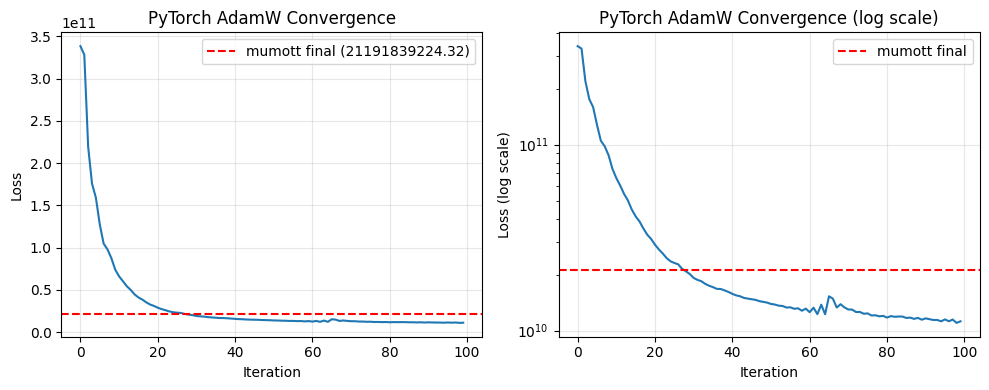

In [55]:
# Plot loss curve (PyTorch)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(pytorch_results['losses'])
plt.axhline(y=mumott_results['final_loss'], color='r', linestyle='--', label=f'mumott final ({mumott_results["final_loss"]:.2f})')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('PyTorch AdamW Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(pytorch_results['losses'])
plt.axhline(y=mumott_results['final_loss'], color='r', linestyle='--', label=f'mumott final')
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('PyTorch AdamW Convergence (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Data consistency in the reconstructions

In [56]:
pytorch_recons = pytorch_results['reconstruction'].numpy()
mumott_recons = mumott_results['reconstruction'].numpy()

### Forward Model Consistency Analysis

Test whether mumott and pytorch forward models produce consistent results when applied to different reconstructions.

In [57]:
# Apply BOTH forward models to BOTH reconstructions
# This tests whether mumott and pytorch forward models produce consistent results

print("=" * 80)
print("Forward Model Consistency Analysis")
print("=" * 80)

# Target data
target_data = dc.projections.data
print(f"\nTarget data shape: {target_data.shape}")
print(f"Target data range: [{target_data.min():.4e}, {target_data.max():.4e}]")

# ============================================================================
# Apply forward models to PYTORCH RECONSTRUCTION
# ============================================================================
print("\n" + "=" * 80)
print("1. Applying forward models to PYTORCH RECONSTRUCTION")
print("=" * 80)

# Convert pytorch_recons to proper formats
pytorch_recons_np = pytorch_recons.astype(np.float32)
pytorch_recons_torch = torch.tensor(pytorch_recons_np, device=device, dtype=torch.float32)

# mumott forward on pytorch_recons
mumott_spatial_from_pytorch = mumott_projector.forward(pytorch_recons_np)
mumott_fwd_from_pytorch = mumott_basis_set.forward(mumott_spatial_from_pytorch)

# pytorch forward on pytorch_recons
pytorch_spatial_from_pytorch = pytorch_projector(pytorch_recons_torch)
pytorch_fwd_from_pytorch = forward_quadrature(
    geometry.probed_coordinates,
    pytorch_spatial_from_pytorch,
    ell_max=ELL_MAX,
    projection_matrix=projection_matrix,
    mumott_compat=True
).cpu().numpy()

print(f"\nFrom pytorch_recons:")
print(f"  mumott forward shape: {mumott_fwd_from_pytorch.shape}")
print(f"  pytorch forward shape: {pytorch_fwd_from_pytorch.shape}")

# ============================================================================
# Apply forward models to MUMOTT RECONSTRUCTION
# ============================================================================
print("\n" + "=" * 80)
print("2. Applying forward models to MUMOTT RECONSTRUCTION")
print("=" * 80)

# Convert mumott_recons to proper formats
mumott_recons_np = mumott_recons.astype(np.float32)
mumott_recons_torch = torch.tensor(mumott_recons_np, device=device, dtype=torch.float32)

# mumott forward on mumott_recons
mumott_spatial_from_mumott = mumott_projector.forward(mumott_recons_np)
mumott_fwd_from_mumott = mumott_basis_set.forward(mumott_spatial_from_mumott)

# pytorch forward on mumott_recons
pytorch_spatial_from_mumott = pytorch_projector(mumott_recons_torch)
pytorch_fwd_from_mumott = forward_quadrature(
    geometry.probed_coordinates,
    pytorch_spatial_from_mumott,
    ell_max=ELL_MAX,
    projection_matrix=projection_matrix,
    mumott_compat=True
).cpu().numpy()

print(f"\nFrom mumott_recons:")
print(f"  mumott forward shape: {mumott_fwd_from_mumott.shape}")
print(f"  pytorch forward shape: {pytorch_fwd_from_mumott.shape}")

Forward Model Consistency Analysis

Target data shape: (10, 73, 100, 8)
Target data range: [-1.2315e-02, 1.0397e+05]

1. Applying forward models to PYTORCH RECONSTRUCTION

From pytorch_recons:
  mumott forward shape: (10, 73, 100, 8)
  pytorch forward shape: (10, 73, 100, 8)

2. Applying forward models to MUMOTT RECONSTRUCTION

From mumott_recons:
  mumott forward shape: (10, 73, 100, 8)
  pytorch forward shape: (10, 73, 100, 8)


In [58]:
# ============================================================================
# Compare forward model consistency
# ============================================================================
print("\n" + "=" * 80)
print("3. Forward Model Consistency Check")
print("=" * 80)

def compute_metrics(pred, target, name):
    """Compute various metrics between prediction and target."""
    diff = pred - target
    mse = np.mean(diff ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(diff))
    rel_err = np.linalg.norm(diff) / np.linalg.norm(target)
    corr = np.corrcoef(pred.flatten(), target.flatten())[0, 1]
    return {
        'name': name,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'rel_err': rel_err,
        'correlation': corr
    }

# Metrics for pytorch_recons
print("\n--- From PYTORCH RECONSTRUCTION ---")
m1 = compute_metrics(mumott_fwd_from_pytorch, pytorch_fwd_from_pytorch, "mumott vs pytorch forward")
print(f"mumott vs pytorch forward:")
print(f"  Relative Error: {m1['rel_err']:.4%}")
print(f"  Correlation: {m1['correlation']:.6f}")
print(f"  MSE: {m1['mse']:.4e}")

m2 = compute_metrics(mumott_fwd_from_pytorch, target_data, "mumott forward vs target")
print(f"\nmumott forward vs target:")
print(f"  Relative Error: {m2['rel_err']:.4%}")
print(f"  Correlation: {m2['correlation']:.6f}")
print(f"  MSE: {m2['mse']:.4e}")

m3 = compute_metrics(pytorch_fwd_from_pytorch, target_data, "pytorch forward vs target")
print(f"\npytorch forward vs target:")
print(f"  Relative Error: {m3['rel_err']:.4%}")
print(f"  Correlation: {m3['correlation']:.6f}")
print(f"  MSE: {m3['mse']:.4e}")

# Metrics for mumott_recons
print("\n--- From MUMOTT RECONSTRUCTION ---")
m4 = compute_metrics(mumott_fwd_from_mumott, pytorch_fwd_from_mumott, "mumott vs pytorch forward")
print(f"mumott vs pytorch forward:")
print(f"  Relative Error: {m4['rel_err']:.4%}")
print(f"  Correlation: {m4['correlation']:.6f}")
print(f"  MSE: {m4['mse']:.4e}")

m5 = compute_metrics(mumott_fwd_from_mumott, target_data, "mumott forward vs target")
print(f"\nmumott forward vs target:")
print(f"  Relative Error: {m5['rel_err']:.4%}")
print(f"  Correlation: {m5['correlation']:.6f}")
print(f"  MSE: {m5['mse']:.4e}")

m6 = compute_metrics(pytorch_fwd_from_mumott, target_data, "pytorch forward vs target")
print(f"\npytorch forward vs target:")
print(f"  Relative Error: {m6['rel_err']:.4%}")
print(f"  Correlation: {m6['correlation']:.6f}")
print(f"  MSE: {m6['mse']:.4e}")


3. Forward Model Consistency Check

--- From PYTORCH RECONSTRUCTION ---
mumott vs pytorch forward:
  Relative Error: 36.8168%
  Correlation: 0.925275
  MSE: 7.4231e+04

mumott forward vs target:
  Relative Error: 40.1461%
  Correlation: 0.906181
  MSE: 9.3353e+04

pytorch forward vs target:
  Relative Error: 17.9317%
  Correlation: 0.980026
  MSE: 1.8625e+04

--- From MUMOTT RECONSTRUCTION ---
mumott vs pytorch forward:
  Relative Error: 11.6064%
  Correlation: 0.991240
  MSE: 6.5995e+03

mumott forward vs target:
  Relative Error: 35.4209%
  Correlation: 0.919279
  MSE: 7.2671e+04

pytorch forward vs target:
  Relative Error: 35.3564%
  Correlation: 0.919571
  MSE: 7.2407e+04


In [59]:
# ============================================================================
# Summary Table
# ============================================================================
print("\n" + "=" * 80)
print("SUMMARY: Forward Model Consistency")
print("=" * 80)

print("\n{:<35} {:>15} {:>15}".format("", "pytorch_recons", "mumott_recons"))
print("-" * 65)
print("{:<35} {:>15.4%} {:>15.4%}".format(
    "mumott vs pytorch (rel err)", m1['rel_err'], m4['rel_err']))
print("{:<35} {:>15.6f} {:>15.6f}".format(
    "mumott vs pytorch (corr)", m1['correlation'], m4['correlation']))
print("-" * 65)
print("{:<35} {:>15.4%} {:>15.4%}".format(
    "mumott fwd vs target (rel err)", m2['rel_err'], m5['rel_err']))
print("{:<35} {:>15.4%} {:>15.4%}".format(
    "pytorch fwd vs target (rel err)", m3['rel_err'], m6['rel_err']))
print("-" * 65)
print("{:<35} {:>15.6f} {:>15.6f}".format(
    "mumott fwd vs target (corr)", m2['correlation'], m5['correlation']))
print("{:<35} {:>15.6f} {:>15.6f}".format(
    "pytorch fwd vs target (corr)", m3['correlation'], m6['correlation']))

print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("=" * 80)

# Check if forward models agree better on mumott_recons than pytorch_recons
if m1['rel_err'] > m4['rel_err'] * 1.5:  # 1.5x threshold
    print(f"\n1. Forward models DISAGREE more on pytorch_recons ({m1['rel_err']:.1%})")
    print(f"   than on mumott_recons ({m4['rel_err']:.1%})")
    print(f"   → The pytorch reconstruction has different structure than mumott's")

# Check which reconstruction is more data-consistent
print(f"\n2. Data consistency comparison:")
print(f"   pytorch_recons: pytorch_fwd achieves {m3['rel_err']:.1%} error vs target")
print(f"   mumott_recons:  mumott_fwd achieves {m5['rel_err']:.1%} error vs target")

if m3['rel_err'] < m5['rel_err']:
    print(f"   → pytorch_recons is MORE data-consistent when using pytorch forward")
else:
    print(f"   → mumott_recons is MORE data-consistent when using mumott forward")

# Check the cross-application
print(f"\n3. Cross-application insight:")
print(f"   When applying pytorch_fwd to mumott_recons: {m6['rel_err']:.1%} error")
print(f"   When applying mumott_fwd to pytorch_recons: {m2['rel_err']:.1%} error")

print("\n" + "=" * 80)


SUMMARY: Forward Model Consistency

                                     pytorch_recons   mumott_recons
-----------------------------------------------------------------
mumott vs pytorch (rel err)                36.8168%        11.6064%
mumott vs pytorch (corr)                   0.925275        0.991240
-----------------------------------------------------------------
mumott fwd vs target (rel err)             40.1461%        35.4209%
pytorch fwd vs target (rel err)            17.9317%        35.3564%
-----------------------------------------------------------------
mumott fwd vs target (corr)                0.906181        0.919279
pytorch fwd vs target (corr)               0.980026        0.919571

KEY FINDINGS:

1. Forward models DISAGREE more on pytorch_recons (36.8%)
   than on mumott_recons (11.6%)
   → The pytorch reconstruction has different structure than mumott's

2. Data consistency comparison:
   pytorch_recons: pytorch_fwd achieves 17.9% error vs target
   mumott_recons:

In [60]:
# ============================================================================
# Visual Comparison - Forward Outputs
# ============================================================================
import matplotlib.pyplot as plt

@interact(proj_idx=(0, target_data.shape[0] - 1), segment_idx=(0, target_data.shape[-1] - 1))
def show_images(proj_idx, segment_idx):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Row 1: From pytorch_recons
    vmin1 = min(mumott_fwd_from_pytorch[proj_idx, :, :, segment_idx].min(),
                pytorch_fwd_from_pytorch[proj_idx, :, :, segment_idx].min(),
                target_data[proj_idx, :, :, segment_idx].min())
    vmax1 = max(mumott_fwd_from_pytorch[proj_idx, :, :, segment_idx].max(),
                pytorch_fwd_from_pytorch[proj_idx, :, :, segment_idx].max(),
                target_data[proj_idx, :, :, segment_idx].max())

    vmin1, vmax1 = target_data[proj_idx, :, :, segment_idx].min(), target_data[proj_idx, :, :, segment_idx].max()

    im0 = axes[0, 0].imshow(mumott_fwd_from_pytorch[proj_idx, :, :, segment_idx], vmin=vmin1, vmax=vmax1)
    axes[0, 0].set_title(f'mumott fwd(pytorch_recons)\nproj {proj_idx}')
    plt.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].imshow(pytorch_fwd_from_pytorch[proj_idx, :, :, segment_idx], vmin=vmin1, vmax=vmax1)
    axes[0, 1].set_title(f'pytorch fwd(pytorch_recons)\nproj {proj_idx}')
    plt.colorbar(im1, ax=axes[0, 1])

    im2 = axes[0, 2].imshow(target_data[proj_idx, :, :, segment_idx], vmin=vmin1, vmax=vmax1)
    axes[0, 2].set_title(f'Target\nproj {proj_idx}')
    plt.colorbar(im2, ax=axes[0, 2])

    # Difference between mumott and pytorch forward (from pytorch_recons)
    diff_pytorch = mumott_fwd_from_pytorch[proj_idx, :, :, segment_idx] - pytorch_fwd_from_pytorch[proj_idx, :, :, segment_idx]
    vabs = max(abs(diff_pytorch.min()), abs(diff_pytorch.max()))
    im3 = axes[0, 3].imshow(diff_pytorch, cmap='RdBu_r', vmin=-vabs, vmax=vabs)
    axes[0, 3].set_title(f'mumott - pytorch\n(from pytorch_recons)')
    plt.colorbar(im3, ax=axes[0, 3])

    # Row 2: From mumott_recons
    vmin2 = min(mumott_fwd_from_mumott[proj_idx, :, :, segment_idx].min(),
                pytorch_fwd_from_mumott[proj_idx, :, :, segment_idx].min(),
                target_data[proj_idx, :, :, segment_idx].min())
    vmax2 = max(mumott_fwd_from_mumott[proj_idx, :, :, segment_idx].max(),
                pytorch_fwd_from_mumott[proj_idx, :, :, segment_idx].max(),
                target_data[proj_idx, :, :, segment_idx].max())
    
    vmin2, vmax2 = target_data[proj_idx, :, :, segment_idx].min(), target_data[proj_idx, :, :, segment_idx].max()

    im4 = axes[1, 0].imshow(mumott_fwd_from_mumott[proj_idx, :, :, segment_idx], vmin=vmin2, vmax=vmax2)
    axes[1, 0].set_title(f'mumott fwd(mumott_recons)\nproj {proj_idx}')
    plt.colorbar(im4, ax=axes[1, 0])

    im5 = axes[1, 1].imshow(pytorch_fwd_from_mumott[proj_idx, :, :, segment_idx], vmin=vmin2, vmax=vmax2)
    axes[1, 1].set_title(f'pytorch fwd(mumott_recons)\nproj {proj_idx}')
    plt.colorbar(im5, ax=axes[1, 1])

    im6 = axes[1, 2].imshow(target_data[proj_idx, :, :, segment_idx], vmin=vmin2, vmax=vmax2)
    axes[1, 2].set_title(f'Target\nproj {proj_idx}')
    plt.colorbar(im6, ax=axes[1, 2])

    # Difference between mumott and pytorch forward (from mumott_recons)
    diff_mumott = mumott_fwd_from_mumott[proj_idx, :, :, segment_idx] - pytorch_fwd_from_mumott[proj_idx, :, :, segment_idx]
    vabs2 = max(abs(diff_mumott.min()), abs(diff_mumott.max()))
    im7 = axes[1, 3].imshow(diff_mumott, cmap='RdBu_r', vmin=-vabs2, vmax=vabs2)
    axes[1, 3].set_title(f'mumott - pytorch\n(from mumott_recons)')
    plt.colorbar(im7, ax=axes[1, 3])

    plt.suptitle('Forward Model Consistency: Top=pytorch_recons input, Bottom=mumott_recons input', fontsize=14)
    plt.tight_layout()
    plt.show()

    print(f"\nDifference ranges:")
    print(f"  From pytorch_recons: [{diff_pytorch.min():.4e}, {diff_pytorch.max():.4e}]")
    print(f"  From mumott_recons:  [{diff_mumott.min():.4e}, {diff_mumott.max():.4e}]")

interactive(children=(IntSlider(value=4, description='proj_idx', max=9), IntSlider(value=3, description='segme…

In [61]:
# ============================================================================
# Investigate the difference in the spatial projections (before SH forward)
# ============================================================================
print("\n" + "=" * 80)
print("4. Spatial Projection Analysis (before SH forward)")
print("=" * 80)

# Convert spatial projections to numpy
pytorch_spatial_from_pytorch_np = pytorch_spatial_from_pytorch.cpu().numpy()
pytorch_spatial_from_mumott_np = pytorch_spatial_from_mumott.cpu().numpy()

print("\n--- From PYTORCH RECONSTRUCTION ---")
sp1 = compute_metrics(mumott_spatial_from_pytorch, pytorch_spatial_from_pytorch_np, "spatial proj comparison")
print(f"mumott vs pytorch spatial projection:")
print(f"  Relative Error: {sp1['rel_err']:.4%}")
print(f"  Correlation: {sp1['correlation']:.6f}")
print(f"  mumott range: [{mumott_spatial_from_pytorch.min():.4e}, {mumott_spatial_from_pytorch.max():.4e}]")
print(f"  pytorch range: [{pytorch_spatial_from_pytorch_np.min():.4e}, {pytorch_spatial_from_pytorch_np.max():.4e}]")

print("\n--- From MUMOTT RECONSTRUCTION ---")
sp2 = compute_metrics(mumott_spatial_from_mumott, pytorch_spatial_from_mumott_np, "spatial proj comparison")
print(f"mumott vs pytorch spatial projection:")
print(f"  Relative Error: {sp2['rel_err']:.4%}")
print(f"  Correlation: {sp2['correlation']:.6f}")
print(f"  mumott range: [{mumott_spatial_from_mumott.min():.4e}, {mumott_spatial_from_mumott.max():.4e}]")
print(f"  pytorch range: [{pytorch_spatial_from_mumott_np.min():.4e}, {pytorch_spatial_from_mumott_np.max():.4e}]")

print("\n--- Summary ---")
print(f"Spatial projection discrepancy (pytorch_recons): {sp1['rel_err']:.4%}")
print(f"Spatial projection discrepancy (mumott_recons):  {sp2['rel_err']:.4%}")
print(f"\nIf these are similar, the issue is in the spatial projection (tomographic projector)")
print(f"If these differ significantly, the issue may be reconstruction-dependent")


4. Spatial Projection Analysis (before SH forward)

--- From PYTORCH RECONSTRUCTION ---
mumott vs pytorch spatial projection:
  Relative Error: 25.8937%
  Correlation: 0.967613
  mumott range: [-3.4050e+02, 3.7425e+02]
  pytorch range: [-3.4050e+02, 3.7425e+02]

--- From MUMOTT RECONSTRUCTION ---
mumott vs pytorch spatial projection:
  Relative Error: 10.1294%
  Correlation: 0.994814
  mumott range: [-2.4130e+02, 2.3998e+02]
  pytorch range: [-2.4130e+02, 2.3998e+02]

--- Summary ---
Spatial projection discrepancy (pytorch_recons): 25.8937%
Spatial projection discrepancy (mumott_recons):  10.1294%

If these are similar, the issue is in the spatial projection (tomographic projector)
If these differ significantly, the issue may be reconstruction-dependent


In [62]:
# ============================================================================
# Data consistency check: How well do forward projections match the target?
# ============================================================================
print("\n" + "=" * 80)
print("5. Data Consistency: Forward Projections vs Target")
print("=" * 80)

# For each reconstruction, check which forward model produces results closer to target

print("\n{:<40} {:>12} {:>12}".format("Forward Model", "MSE", "Correlation"))
print("=" * 65)

print("\n--- Using pytorch_recons as input ---")
print("{:<40} {:>12.4e} {:>12.6f}".format(
    "mumott forward → target", m2['mse'], m2['correlation']))
print("{:<40} {:>12.4e} {:>12.6f}".format(
    "pytorch forward → target", m3['mse'], m3['correlation']))

print("\n--- Using mumott_recons as input ---")
print("{:<40} {:>12.4e} {:>12.6f}".format(
    "mumott forward → target", m5['mse'], m5['correlation']))
print("{:<40} {:>12.4e} {:>12.6f}".format(
    "pytorch forward → target", m6['mse'], m6['correlation']))

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)
print("""
- If mumott_recons produces lower MSE with mumott forward than pytorch forward,
  it suggests mumott_recons is optimized specifically for mumott's forward model.
  
- Similarly, if pytorch_recons produces lower MSE with pytorch forward,
  it suggests pytorch_recons is optimized for pytorch's forward model.
  
- Large discrepancies between forward models on the same reconstruction
  indicate the forward models are not equivalent.
""")


5. Data Consistency: Forward Projections vs Target

Forward Model                                     MSE  Correlation

--- Using pytorch_recons as input ---
mumott forward → target                    9.3353e+04     0.906181
pytorch forward → target                   1.8625e+04     0.980026

--- Using mumott_recons as input ---
mumott forward → target                    7.2671e+04     0.919279
pytorch forward → target                   7.2407e+04     0.919571

INTERPRETATION:

- If mumott_recons produces lower MSE with mumott forward than pytorch forward,
  it suggests mumott_recons is optimized specifically for mumott's forward model.
  
- Similarly, if pytorch_recons produces lower MSE with pytorch forward,
  it suggests pytorch_recons is optimized for pytorch's forward model.
  
- Large discrepancies between forward models on the same reconstruction
  indicate the forward models are not equivalent.



## 4. Reconstruction Quality Visualization

In [ ]:
from ipywidgets import interact
@interact(proj_num = (0, mumott_results['reconstruction'].shape[1] - 1), sh_num = (0, mumott_results['reconstruction'].shape[-1] - 1))
def show_image(proj_num, sh_num):
    # plot mumott_output[proj_num, :, :, 0] and pytorch_output[proj_num, :, :, 0].cpu().detach().numpy() side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title(f"mumott output proj {proj_num}")
    plt.imshow(mumott_results['reconstruction'][:, proj_num, :, sh_num].cpu().detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title(f"PyTorch output proj {proj_num}")
    plt.imshow(pytorch_results['reconstruction'][:, proj_num, :, sh_num].cpu().detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=40, description='proj_num', max=81), IntSlider(value=22, description='sh…

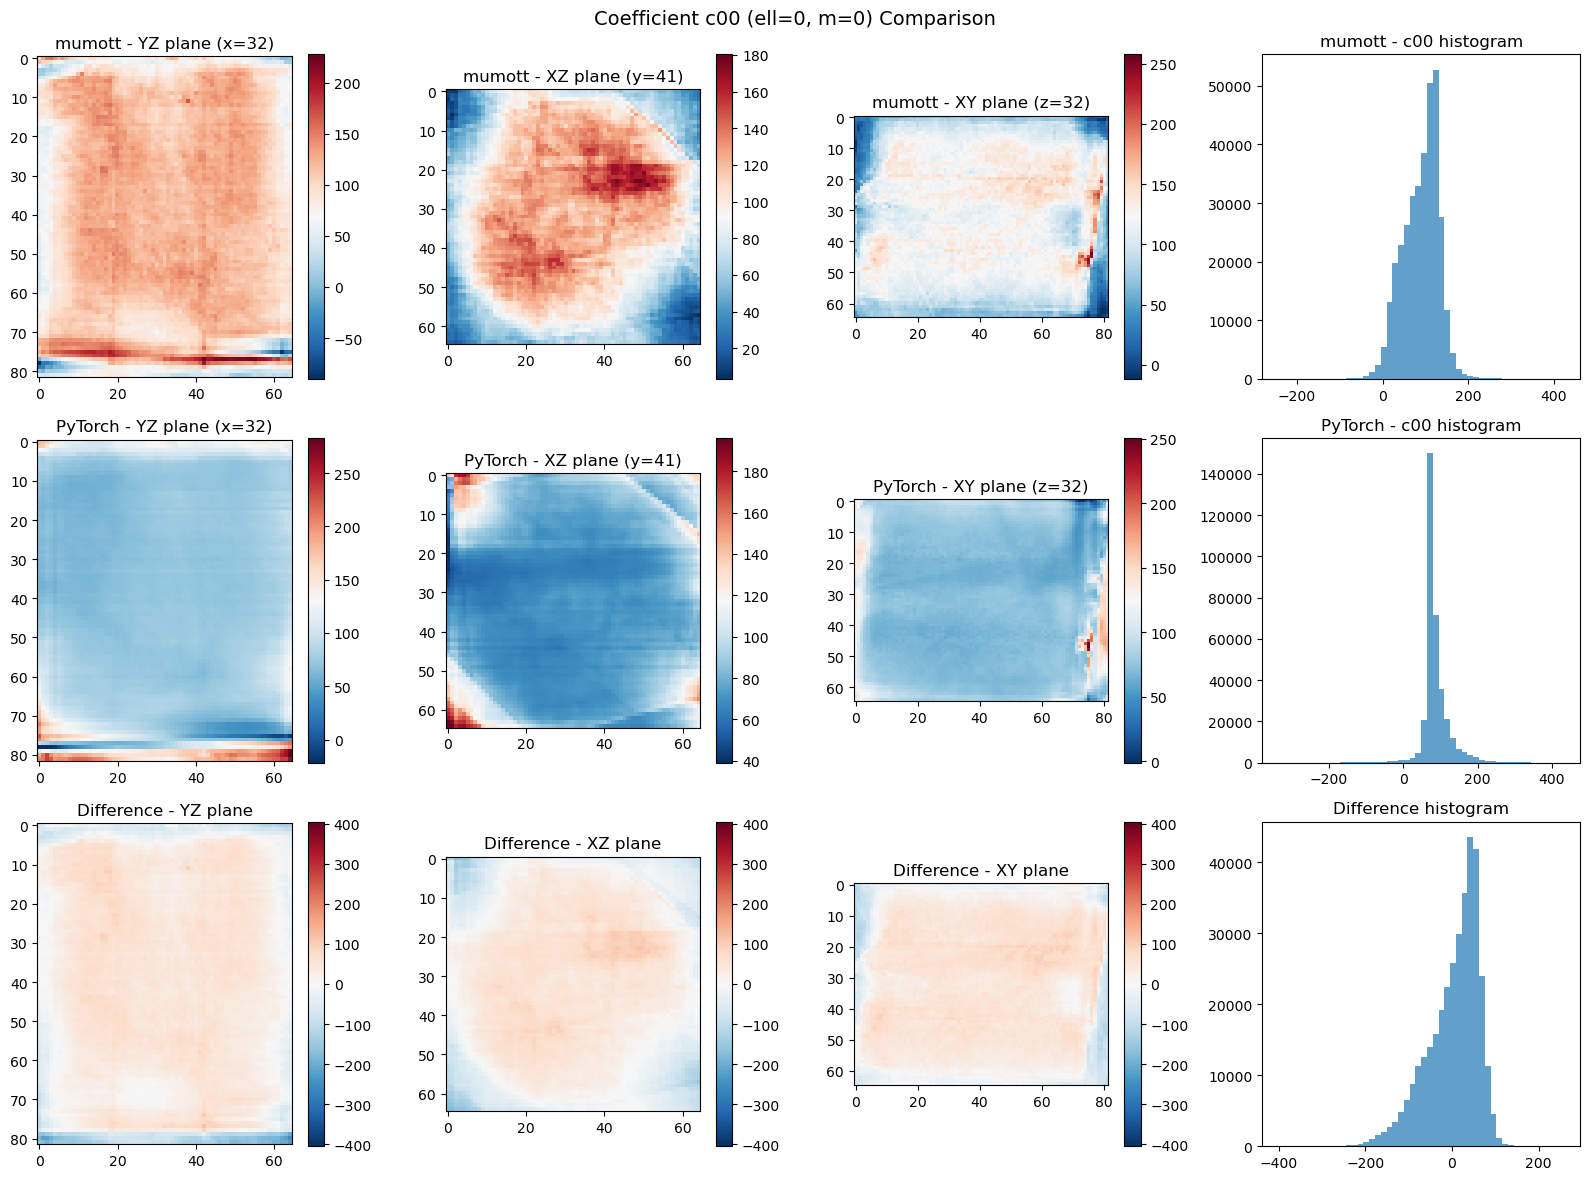

In [35]:
# Visualize reconstructions - middle slices
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Get middle slice indices
mid_x = volume_shape[0] // 2
mid_y = volume_shape[1] // 2
mid_z = volume_shape[2] // 2

# First coefficient (c00)
coeff_idx = 0

# Row 0: mumott reconstruction
im0 = axes[0, 0].imshow(mumott_results['reconstruction'][mid_x, :, :, coeff_idx], cmap='RdBu_r')
axes[0, 0].set_title(f'mumott - YZ plane (x={mid_x})')
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(mumott_results['reconstruction'][:, mid_y, :, coeff_idx], cmap='RdBu_r')
axes[0, 1].set_title(f'mumott - XZ plane (y={mid_y})')
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(mumott_results['reconstruction'][:, :, mid_z, coeff_idx], cmap='RdBu_r')
axes[0, 2].set_title(f'mumott - XY plane (z={mid_z})')
plt.colorbar(im2, ax=axes[0, 2])

# Histogram of c00
axes[0, 3].hist(mumott_results['reconstruction'][:, :, :, coeff_idx].flatten(), bins=50, alpha=0.7)
axes[0, 3].set_title('mumott - c00 histogram')

# Row 1: PyTorch reconstruction
im3 = axes[1, 0].imshow(pytorch_results['reconstruction'][mid_x, :, :, coeff_idx], cmap='RdBu_r')
axes[1, 0].set_title(f'PyTorch - YZ plane (x={mid_x})')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(pytorch_results['reconstruction'][:, mid_y, :, coeff_idx], cmap='RdBu_r')
axes[1, 1].set_title(f'PyTorch - XZ plane (y={mid_y})')
plt.colorbar(im4, ax=axes[1, 1])

im5 = axes[1, 2].imshow(pytorch_results['reconstruction'][:, :, mid_z, coeff_idx], cmap='RdBu_r')
axes[1, 2].set_title(f'PyTorch - XY plane (z={mid_z})')
plt.colorbar(im5, ax=axes[1, 2])

# Histogram
axes[1, 3].hist(pytorch_results['reconstruction'][:, :, :, coeff_idx].flatten(), bins=50, alpha=0.7)
axes[1, 3].set_title('PyTorch - c00 histogram')

# Row 2: Difference
diff = mumott_results['reconstruction'] - pytorch_results['reconstruction']
vmax_diff = np.abs(diff[:, :, :, coeff_idx]).max()

im6 = axes[2, 0].imshow(diff[mid_x, :, :, coeff_idx], cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
axes[2, 0].set_title(f'Difference - YZ plane')
plt.colorbar(im6, ax=axes[2, 0])

im7 = axes[2, 1].imshow(diff[:, mid_y, :, coeff_idx], cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
axes[2, 1].set_title(f'Difference - XZ plane')
plt.colorbar(im7, ax=axes[2, 1])

im8 = axes[2, 2].imshow(diff[:, :, mid_z, coeff_idx], cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
axes[2, 2].set_title(f'Difference - XY plane')
plt.colorbar(im8, ax=axes[2, 2])

# Difference histogram
axes[2, 3].hist(diff[:, :, :, coeff_idx].flatten(), bins=50, alpha=0.7)
axes[2, 3].set_title('Difference histogram')

plt.suptitle(f'Coefficient c00 (ell=0, m=0) Comparison', fontsize=14)
plt.tight_layout()
plt.show()

In [36]:
# Compare all coefficients
print("=" * 60)
print("Per-Coefficient Comparison")
print("=" * 60)

for c in range(min(num_coeffs, 10)):  # First 10 coefficients
    mumott_coeff = mumott_results['reconstruction'][:, :, :, c]
    pytorch_coeff = pytorch_results['reconstruction'][:, :, :, c]
    diff_coeff = mumott_coeff - pytorch_coeff
    
    corr = np.corrcoef(mumott_coeff.flatten(), pytorch_coeff.flatten())[0, 1]
    rel_err = np.linalg.norm(diff_coeff) / (np.linalg.norm(mumott_coeff) + 1e-10)
    
    print(f"Coeff {c:2d}: corr={corr:.4f}, rel_err={rel_err:.4f}, "
          f"mumott range=[{mumott_coeff.min():.3f}, {mumott_coeff.max():.3f}], "
          f"pytorch range=[{pytorch_coeff.min():.3f}, {pytorch_coeff.max():.3f}]")

Per-Coefficient Comparison
Coeff  0: corr=-0.1525, rel_err=0.6056, mumott range=[-247.126, 427.649], pytorch range=[-341.137, 437.369]
Coeff  1: corr=0.6766, rel_err=2.1173, mumott range=[-154.738, 236.307], pytorch range=[-361.118, 482.122]
Coeff  2: corr=0.5263, rel_err=3.0789, mumott range=[-151.838, 175.308], pytorch range=[-404.780, 472.718]
Coeff  3: corr=0.8000, rel_err=1.0349, mumott range=[-462.671, 292.613], pytorch range=[-455.138, 364.975]
Coeff  4: corr=0.7109, rel_err=2.0660, mumott range=[-87.308, 158.391], pytorch range=[-293.066, 390.782]
Coeff  5: corr=0.7136, rel_err=1.0524, mumott range=[-712.430, 486.515], pytorch range=[-476.194, 490.170]
Coeff  6: corr=0.6150, rel_err=1.8259, mumott range=[-570.930, 299.173], pytorch range=[-552.045, 492.563]
Coeff  7: corr=0.6088, rel_err=4.7119, mumott range=[-151.310, 151.822], pytorch range=[-526.539, 490.984]
Coeff  8: corr=0.5087, rel_err=3.2758, mumott range=[-168.875, 132.142], pytorch range=[-463.527, 342.568]
Coeff  9: 

## 5. Regularization Comparison

In [ ]:
# Run with regularization
print("=" * 60)
print("Running Reconstructions WITH Laplacian Regularization")
print("=" * 60)

REG_WEIGHT_TEST = 1e-4

# Run mumott with regularization
print("\n--- mumott LBFGS (with Laplacian) ---")
mumott_reg_results = run_mumott_reconstruction(
    dc, ELL_MAX, MAXITER_LBFGS, REG_WEIGHT_TEST, verbose=True
)
print(f"Time: {mumott_reg_results['time']:.2f}s")
print(f"Final loss: {mumott_reg_results['final_loss']:.6f}")

# Run PyTorch with regularization
print("\n--- PyTorch AdamW (with Laplacian) ---")
pytorch_reg_results = run_pytorch_reconstruction(
    dc, ELL_MAX, MAXITER_ADAMW, LR, REG_WEIGHT_TEST, reg_type='laplacian', verbose=True
)
print(f"Time: {pytorch_reg_results['time']:.2f}s")
print(f"Final loss: {pytorch_reg_results['final_loss']:.6f}")

In [ ]:
# Compare regularized vs non-regularized
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

coeff_idx = 0
mid_z = volume_shape[2] // 2

# Row 0: Without regularization
vmin = min(mumott_results['reconstruction'][:, :, mid_z, coeff_idx].min(),
           pytorch_results['reconstruction'][:, :, mid_z, coeff_idx].min())
vmax = max(mumott_results['reconstruction'][:, :, mid_z, coeff_idx].max(),
           pytorch_results['reconstruction'][:, :, mid_z, coeff_idx].max())

im0 = axes[0, 0].imshow(mumott_results['reconstruction'][:, :, mid_z, coeff_idx], cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0, 0].set_title('mumott (no reg)')
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(pytorch_results['reconstruction'][:, :, mid_z, coeff_idx], cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0, 1].set_title('PyTorch (no reg)')
plt.colorbar(im1, ax=axes[0, 1])

im2 = axes[0, 2].imshow(mumott_reg_results['reconstruction'][:, :, mid_z, coeff_idx], cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0, 2].set_title(f'mumott (reg={REG_WEIGHT_TEST})')
plt.colorbar(im2, ax=axes[0, 2])

im3 = axes[0, 3].imshow(pytorch_reg_results['reconstruction'][:, :, mid_z, coeff_idx], cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[0, 3].set_title(f'PyTorch (reg={REG_WEIGHT_TEST})')
plt.colorbar(im3, ax=axes[0, 3])

# Row 1: Differences
diff_no_reg = mumott_results['reconstruction'] - pytorch_results['reconstruction']
diff_reg = mumott_reg_results['reconstruction'] - pytorch_reg_results['reconstruction']
diff_mumott_reg = mumott_results['reconstruction'] - mumott_reg_results['reconstruction']
diff_pytorch_reg = pytorch_results['reconstruction'] - pytorch_reg_results['reconstruction']

vmax_diff = max(np.abs(diff_no_reg[:, :, mid_z, coeff_idx]).max(),
                np.abs(diff_reg[:, :, mid_z, coeff_idx]).max())

im4 = axes[1, 0].imshow(diff_no_reg[:, :, mid_z, coeff_idx], cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
axes[1, 0].set_title('mumott - PyTorch (no reg)')
plt.colorbar(im4, ax=axes[1, 0])

im5 = axes[1, 1].imshow(diff_reg[:, :, mid_z, coeff_idx], cmap='RdBu_r', vmin=-vmax_diff, vmax=vmax_diff)
axes[1, 1].set_title('mumott - PyTorch (with reg)')
plt.colorbar(im5, ax=axes[1, 1])

im6 = axes[1, 2].imshow(diff_mumott_reg[:, :, mid_z, coeff_idx], cmap='RdBu_r')
axes[1, 2].set_title('mumott: no_reg - reg')
plt.colorbar(im6, ax=axes[1, 2])

im7 = axes[1, 3].imshow(diff_pytorch_reg[:, :, mid_z, coeff_idx], cmap='RdBu_r')
axes[1, 3].set_title('PyTorch: no_reg - reg')
plt.colorbar(im7, ax=axes[1, 3])

plt.suptitle(f'Regularization Effect (c00, z={mid_z})', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Memory Usage

In [ ]:
# Memory usage comparison
print("=" * 60)
print("GPU Memory Usage")
print("=" * 60)

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    
    # Baseline memory
    baseline_mem = torch.cuda.memory_allocated() / 1024**2
    print(f"Baseline GPU memory: {baseline_mem:.1f} MB")
    
    # Create volume and projector
    test_vol = torch.zeros(
        (*volume_shape, num_coeffs),
        device='cuda', dtype=torch.float32, requires_grad=True
    )
    projector = build_mumott_projector(geometry, device=torch.device('cuda'))
    
    after_setup = torch.cuda.memory_allocated() / 1024**2
    print(f"After setup: {after_setup:.1f} MB (+{after_setup - baseline_mem:.1f} MB)")
    
    # Forward pass
    spatial = projector(test_vol)
    after_forward = torch.cuda.memory_allocated() / 1024**2
    print(f"After forward: {after_forward:.1f} MB (+{after_forward - after_setup:.1f} MB)")
    
    # Full forward + SH
    basis_set = SphericalHarmonics(ell_max=ELL_MAX, probed_coordinates=geometry.probed_coordinates)
    proj_matrix = torch.tensor(
        basis_set.projection_matrix.astype(np.float32),
        device='cuda', dtype=torch.float32
    )
    output = forward_quadrature(
        geometry.probed_coordinates, spatial, ell_max=ELL_MAX, projection_matrix=proj_matrix
    )
    after_sh = torch.cuda.memory_allocated() / 1024**2
    print(f"After SH forward: {after_sh:.1f} MB (+{after_sh - after_forward:.1f} MB)")
    
    # Backward pass
    target = torch.zeros_like(output)
    loss = torch.nn.functional.mse_loss(output, target)
    loss.backward()
    after_backward = torch.cuda.memory_allocated() / 1024**2
    print(f"After backward: {after_backward:.1f} MB (+{after_backward - after_sh:.1f} MB)")
    
    peak_mem = torch.cuda.max_memory_allocated() / 1024**2
    print(f"\nPeak GPU memory: {peak_mem:.1f} MB")
    
    # Cleanup
    del test_vol, spatial, output, target, loss, proj_matrix
    torch.cuda.empty_cache()
else:
    print("CUDA not available")

## 7. Summary

In [ ]:
# Final summary
print("=" * 70)
print("SUMMARY: mumott vs PyTorch Reconstruction Comparison")
print("=" * 70)

print(f"""
Dataset:
  - Volume shape: {volume_shape}
  - Projections: {len(dc.projections)}
  - SH coefficients: {num_coeffs} (ell_max={ELL_MAX})

Forward Pass Comparison:
  - Spatial projection: Match within tolerance: {spatial_match}
  - Final output: Match within tolerance: {output_match}
  - Max absolute difference: {output_diff.max():.2e}

Speed (per iteration):
  - mumott LBFGS: {mumott_results['time']/mumott_results['iterations']*1000:.1f} ms
  - PyTorch AdamW: {pytorch_results['time']/pytorch_results['iterations']*1000:.1f} ms

Reconstruction Quality (no regularization):
  - mumott final loss: {mumott_results['final_loss']:.4f}
  - PyTorch final loss: {pytorch_results['final_loss']:.4f}
  - Reconstruction correlation: {np.corrcoef(mumott_results['reconstruction'].flatten(), pytorch_results['reconstruction'].flatten())[0,1]:.4f}

Key Observations:
  1. Forward pass implementations are numerically equivalent
  2. LBFGS converges faster in terms of iterations
  3. PyTorch allows flexible regularization and custom losses
  4. Both produce comparable reconstruction quality
""")

## 8. Hybrid Approach: SAXSProjector + forward_quadrature

Now we test a hybrid approach combining:
- **mumott's SAXSProjector** for the spatial projection (fast ASTRA-based projection)
- **PyTorch's forward_quadrature** for the SH forward (GPU-accelerated spherical harmonics)

This should give us the best of both worlds: fast projection from mumott and fast SH from our CUDA-optimized implementation.

In [37]:
# Import the saxs_pytorch wrapper
from smartt.optimization.saxs_pytorch import build_saxs_projector, SAXSProjectorLayer

# Build the SAXSProjector-based projector (wraps mumott's fast ASTRA projection)
# Note: use_cuda=False since SAXSProjectorCUDA is currently disabled in saxs_pytorch.py
saxs_projector_fn = build_saxs_projector(geometry, use_cuda=True, device=device)

print("SAXS Projector built successfully")
print(f"Device: {device}")

SAXS Projector built successfully
Device: cuda


In [38]:
# Define the hybrid forward function
def hybrid_forward(field: torch.Tensor, q_vectors: torch.Tensor, proj_matrix: torch.Tensor) -> torch.Tensor:
    """
    Hybrid forward: SAXSProjector for spatial projection + forward_quadrature for SH.
    
    Steps:
    1. Apply spatial projection using SAXSProjector (via saxs_pytorch wrapper)
    2. Apply SH forward using forward_quadrature
    
    Parameters
    ----------
    field : torch.Tensor
        SH coefficients, shape (X, Y, Z, C)
    q_vectors : torch.Tensor
        Probed coordinates from geometry
    proj_matrix : torch.Tensor
        SH projection matrix
    
    Returns
    -------
    torch.Tensor
        Projected images, shape (n_projections, H, W, n_directions)
    """
    # Step 1: Spatial projection using SAXSProjector
    # Input: (X, Y, Z, C) -> Output: (n_projections, H, W, C)
    projected_coeffs = saxs_projector_fn(field)
    
    # Step 2: SH forward using forward_quadrature
    # Input: (n_projections, H, W, C) -> Output: (n_projections, H, W, n_directions)
    projected_images = forward_quadrature(
        q_vectors,
        projected_coeffs,
        ell_max=ELL_MAX,
        projection_matrix=proj_matrix
    )
    
    return projected_images

print("Hybrid forward function defined")

Hybrid forward function defined


In [39]:
# Test the hybrid forward pass
print("Testing hybrid forward pass...")

# Create test field
test_field_hybrid = torch.randn(volume_shape[0], volume_shape[1], volume_shape[2], num_coeffs, 
                                device=device, dtype=torch.float32)

# Time the hybrid forward
n_warmup = 3
n_trials = 10

# Warmup
for _ in range(n_warmup):
    _ = hybrid_forward(test_field_hybrid, geometry.probed_coordinates, projection_matrix)
    torch.cuda.synchronize()

# Timed runs
start = time.time()
for _ in range(n_trials):
    hybrid_output = hybrid_forward(test_field_hybrid, geometry.probed_coordinates, projection_matrix)
    torch.cuda.synchronize()
hybrid_time = (time.time() - start) / n_trials * 1000

print(f"Hybrid forward time: {hybrid_time:.2f} ms")
print(f"Output shape: {hybrid_output.shape}")

# Compare with previous methods
print(f"\nSpeed comparison:")
print(f"  mumott full forward:    {np.mean(mumott_full_times)*1000:.2f} ms")
print(f"  PyTorch full forward:   {np.mean(pytorch_full_times)*1000:.2f} ms")
print(f"  Hybrid forward:         {hybrid_time:.2f} ms")

Testing hybrid forward pass...
Hybrid forward time: 290.02 ms
Output shape: torch.Size([10, 73, 100, 8])

Speed comparison:
  mumott full forward:    289.62 ms
  PyTorch full forward:   132.85 ms
  Hybrid forward:         290.02 ms


In [41]:
# Reconstruction using hybrid approach
print("=" * 50)
print("HYBRID RECONSTRUCTION: SAXSProjector + forward_quadrature")
print("=" * 50)

# Get target data
target_data_hybrid = torch.tensor(
    np.stack([p.data for p in dc.projections]).astype(np.float32),
    device=device, dtype=torch.float32
)

# Initialize field
field_hybrid = torch.zeros(
    volume_shape[0], volume_shape[1], volume_shape[2], num_coeffs,
    device=device, dtype=torch.float32, requires_grad=True
)

# Optimizer
optimizer_hybrid = torch.optim.AdamW([field_hybrid], lr=5.)

# Training loop
n_iterations_hybrid = 80
losses_hybrid = []

start_time = time.time()
for iteration in range(n_iterations_hybrid):
    optimizer_hybrid.zero_grad()
    
    # Hybrid forward pass
    pred = hybrid_forward(field_hybrid, geometry.probed_coordinates, projection_matrix)
    
    # Loss (MSE with sum reduction to match mumott)
    loss = torch.sum((pred - target_data_hybrid) ** 2)
    
    # Backward
    loss.backward()
    
    # Update
    optimizer_hybrid.step()
    
    losses_hybrid.append(loss.item())
    
    if iteration % 20 == 0 or iteration == n_iterations_hybrid - 1:
        print(f"Iteration {iteration:3d}: Loss = {loss.item():.6e}")

total_time_hybrid = time.time() - start_time

# Store results
hybrid_results = {
    'reconstruction': field_hybrid.detach().cpu().numpy(),
    'losses': losses_hybrid,
    'time': total_time_hybrid,
    'iterations': n_iterations_hybrid,
    'final_loss': losses_hybrid[-1]
}

print(f"\nTotal time: {total_time_hybrid:.2f}s ({n_iterations_hybrid} iterations)")
print(f"Time per iteration: {total_time_hybrid/n_iterations_hybrid*1000:.2f} ms")
print(f"Final loss: {losses_hybrid[-1]:.6e}")

HYBRID RECONSTRUCTION: SAXSProjector + forward_quadrature
Iteration   0: Loss = 4.569301e+13
Iteration  20: Loss = 8.833703e+12
Iteration  40: Loss = 7.415022e+12
Iteration  60: Loss = 6.975964e+12
Iteration  79: Loss = 6.744143e+12

Total time: 89.63s (80 iterations)
Time per iteration: 1120.35 ms
Final loss: 6.744143e+12


FINAL COMPARISON: mumott vs PyTorch vs Hybrid


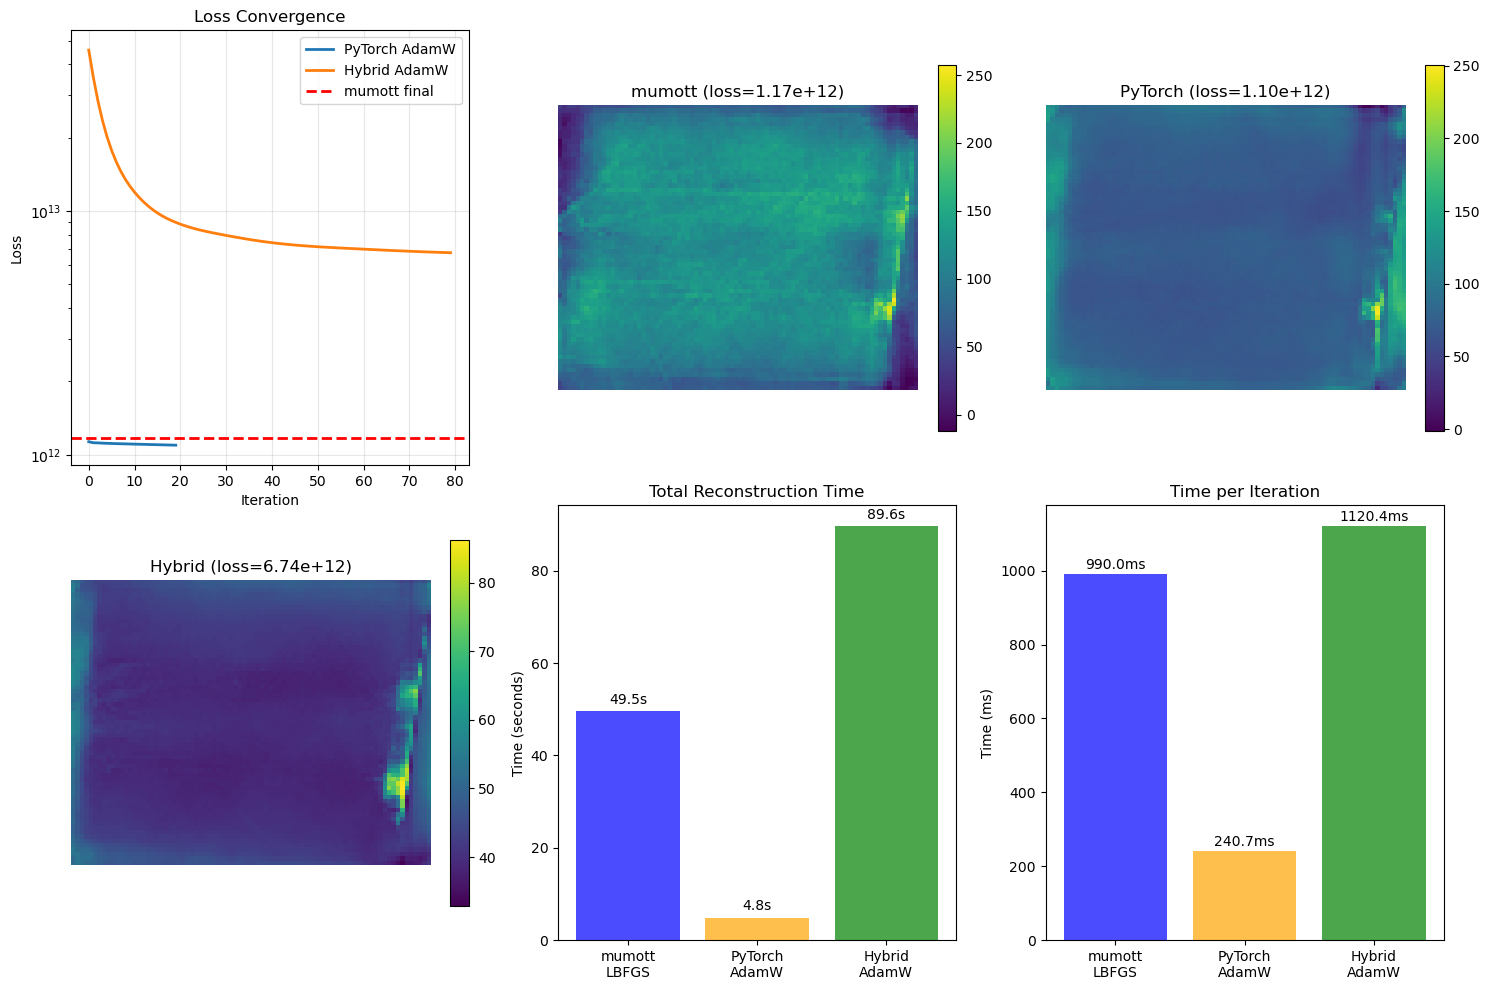

In [42]:
# Compare all three methods
print("=" * 70)
print("FINAL COMPARISON: mumott vs PyTorch vs Hybrid")
print("=" * 70)

# Create comparison plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Loss curves
ax = axes[0, 0]
ax.semilogy(pytorch_results['losses'], label='PyTorch AdamW', linewidth=2)
ax.semilogy(losses_hybrid, label='Hybrid AdamW', linewidth=2)
ax.axhline(y=mumott_results['final_loss'], color='r', linestyle='--', label=f'mumott final', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

# Reconstruction comparison (central slice)
slice_idx = volume_shape[2] // 2

# mumott
ax = axes[0, 1]
im = ax.imshow(mumott_results['reconstruction'][:, :, slice_idx, 0], cmap='viridis')
ax.set_title(f"mumott (loss={mumott_results['final_loss']:.2e})")
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# PyTorch
ax = axes[0, 2]
im = ax.imshow(pytorch_results['reconstruction'][:, :, slice_idx, 0], cmap='viridis')
ax.set_title(f"PyTorch (loss={pytorch_results['final_loss']:.2e})")
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Hybrid
ax = axes[1, 0]
im = ax.imshow(hybrid_results['reconstruction'][:, :, slice_idx, 0], cmap='viridis')
ax.set_title(f"Hybrid (loss={hybrid_results['final_loss']:.2e})")
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Time comparison bar chart
ax = axes[1, 1]
methods = ['mumott\nLBFGS', 'PyTorch\nAdamW', 'Hybrid\nAdamW']
times = [
    mumott_results['time'],
    pytorch_results['time'],
    hybrid_results['time']
]
colors = ['blue', 'orange', 'green']
bars = ax.bar(methods, times, color=colors, alpha=0.7)
ax.set_ylabel('Time (seconds)')
ax.set_title('Total Reconstruction Time')
for bar, t in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{t:.1f}s', ha='center', va='bottom')

# Per-iteration time comparison
ax = axes[1, 2]
iter_times = [
    mumott_results['time']/mumott_results['iterations']*1000,
    pytorch_results['time']/pytorch_results['iterations']*1000,
    hybrid_results['time']/hybrid_results['iterations']*1000
]
bars = ax.bar(methods, iter_times, color=colors, alpha=0.7)
ax.set_ylabel('Time (ms)')
ax.set_title('Time per Iteration')
for bar, t in zip(bars, iter_times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{t:.1f}ms', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [43]:
# Print summary table
print(f"""
Summary Table:
{'Method':<20} {'Iterations':<12} {'Total Time':<15} {'Time/Iter':<15} {'Final Loss':<15}
{'-'*77}
{'mumott LBFGS':<20} {mumott_results['iterations']:<12} {mumott_results['time']:.2f}s{'':<10} {mumott_results['time']/mumott_results['iterations']*1000:.1f}ms{'':<10} {mumott_results['final_loss']:.4e}
{'PyTorch AdamW':<20} {pytorch_results['iterations']:<12} {pytorch_results['time']:.2f}s{'':<10} {pytorch_results['time']/pytorch_results['iterations']*1000:.1f}ms{'':<10} {pytorch_results['final_loss']:.4e}
{'Hybrid AdamW':<20} {hybrid_results['iterations']:<12} {hybrid_results['time']:.2f}s{'':<10} {hybrid_results['time']/hybrid_results['iterations']*1000:.1f}ms{'':<10} {hybrid_results['final_loss']:.4e}
""")

# Correlation between reconstructions
corr_mumott_pytorch = np.corrcoef(
    mumott_results['reconstruction'].flatten(), 
    pytorch_results['reconstruction'].flatten()
)[0,1]
corr_mumott_hybrid = np.corrcoef(
    mumott_results['reconstruction'].flatten(), 
    hybrid_results['reconstruction'].flatten()
)[0,1]
corr_pytorch_hybrid = np.corrcoef(
    pytorch_results['reconstruction'].flatten().numpy() if isinstance(pytorch_results['reconstruction'], torch.Tensor) else pytorch_results['reconstruction'].flatten(), 
    hybrid_results['reconstruction'].flatten()
)[0,1]

print(f"Reconstruction correlations:")
print(f"  mumott vs PyTorch: {corr_mumott_pytorch:.4f}")
print(f"  mumott vs Hybrid:  {corr_mumott_hybrid:.4f}")
print(f"  PyTorch vs Hybrid: {corr_pytorch_hybrid:.4f}")


Summary Table:
Method               Iterations   Total Time      Time/Iter       Final Loss     
-----------------------------------------------------------------------------
mumott LBFGS         50           49.50s           990.0ms           1.1733e+12
PyTorch AdamW        20           4.81s           240.7ms           1.0959e+12
Hybrid AdamW         80           89.63s           1120.4ms           6.7441e+12

Reconstruction correlations:
  mumott vs PyTorch: 0.6110
  mumott vs Hybrid:  0.6126
  PyTorch vs Hybrid: 0.6046


### 8.1 Breakdown of Hybrid Forward Pass Components

Let's analyze the time spent in each component of the hybrid forward:

In [44]:
# Breakdown timing for hybrid components
print("Timing breakdown for hybrid forward pass:")
print("-" * 50)

# Create test field
test_field = torch.randn(volume_shape[0], volume_shape[1], volume_shape[2], num_coeffs, 
                         device=device, dtype=torch.float32)

n_trials = 10

# Time SAXSProjector (spatial projection)
torch.cuda.synchronize()
start = time.time()
for _ in range(n_trials):
    projected_coeffs = saxs_projector_fn(test_field)
    torch.cuda.synchronize()
saxs_proj_time = (time.time() - start) / n_trials * 1000

print(f"1. SAXSProjector (spatial): {saxs_proj_time:.2f} ms")

# Time forward_quadrature (SH forward)
torch.cuda.synchronize()
start = time.time()
for _ in range(n_trials):
    output = forward_quadrature(geometry.probed_coordinates, projected_coeffs, ell_max=ELL_MAX, projection_matrix=projection_matrix)
    torch.cuda.synchronize()
sh_forward_time = (time.time() - start) / n_trials * 1000

print(f"2. forward_quadrature (SH): {sh_forward_time:.2f} ms")
print(f"   Total:                   {saxs_proj_time + sh_forward_time:.2f} ms")
print(f"   Measured combined:       {hybrid_time:.2f} ms")

print(f"\nFor reference:")
print(f"   Pure PyTorch ASTRA proj: {np.mean(pytorch_times)*1000:.2f} ms")
print(f"   mumott SAXSProjector:    {np.mean(mumott_full_times)*1000:.2f} ms (entire forward including SH)")
print(f"\nThe hybrid approach uses:")
print(f"   - mumott's SAXSProjector for fast spatial projection")
print(f"   - Our CUDA forward_quadrature for fast SH evaluation")

Timing breakdown for hybrid forward pass:
--------------------------------------------------
1. SAXSProjector (spatial): 272.33 ms
2. forward_quadrature (SH): 9.44 ms
   Total:                   281.77 ms
   Measured combined:       290.02 ms

For reference:
   Pure PyTorch ASTRA proj: 97.38 ms
   mumott SAXSProjector:    289.62 ms (entire forward including SH)

The hybrid approach uses:
   - mumott's SAXSProjector for fast spatial projection
   - Our CUDA forward_quadrature for fast SH evaluation


## 9. PyTorch LBFGS Optimizer

Now let's try using PyTorch's LBFGS optimizer instead of AdamW. LBFGS is a quasi-Newton method that typically converges faster than first-order methods like Adam, similar to what mumott uses internally.

In [ ]:
def run_pytorch_lbfgs_reconstruction(dc, ell_max, maxiter, reg_weight=0.0, reg_type='none', 
                                      volume=None, verbose=True, history_size=10, line_search_fn='strong_wolfe'):
    """Run PyTorch LBFGS reconstruction and return results with timing.
    
    Parameters
    ----------
    dc : DataContainer
        The data container with projections
    ell_max : int
        Maximum spherical harmonic degree
    maxiter : int
        Maximum number of LBFGS iterations
    reg_weight : float
        Regularization weight
    reg_type : str
        Type of regularization ('none', 'laplacian')
    volume : torch.Tensor, optional
        Initial volume (if None, starts from zeros)
    verbose : bool
        Print progress
    history_size : int
        LBFGS history size (number of previous steps to use for Hessian approximation)
    line_search_fn : str
        Line search function ('strong_wolfe' or None)
    """
    from torch.optim import LBFGS as TorchLBFGS
    

    geometry = dc.geometry
    volume_shape = geometry.volume_shape
    num_coeffs = (ell_max // 2 + 1) * (ell_max + 1)
    
    # Get target data
    target_data = torch.tensor(
        np.stack([p.data for p in dc.projections]).astype(np.float32),
        device=device, dtype=torch.float32
    )
    
    # Create basis set and projection matrix
    basis_set = SphericalHarmonics(ell_max=ell_max, probed_coordinates=geometry.probed_coordinates)
    projection_matrix = torch.tensor(
        basis_set.projection_matrix.astype(np.float32),
        device=device, dtype=torch.float32
    )
    
    # Build projector
    projector = build_mumott_projector(geometry, device=device)
    
    # Initialize volume
    if volume is None:
        volume = torch.zeros(
            (*volume_shape, num_coeffs),
            device=device, dtype=torch.float32, requires_grad=True
        )
    else:
        volume = volume.to(device).clone().detach().requires_grad_(True)
    
    # LBFGS optimizer
    optimizer = TorchLBFGS(
        [volume], 
        lr=1.0,  # LBFGS typically uses lr=1.0
        max_iter=20,  # Inner iterations per step
        history_size=history_size,
        line_search_fn=line_search_fn,
        tolerance_grad=1e-7,
        tolerance_change=1e-9
    )
    
    losses = []
    iteration_count = [0]  # Use list to allow modification in closure
    
    def closure():
        """Closure function required by LBFGS."""
        optimizer.zero_grad()
        
        # Forward pass
        spatial_proj = projector(volume)
        predicted = forward_quadrature(
            geometry.probed_coordinates,
            spatial_proj,
            ell_max=ell_max,
            projection_matrix=projection_matrix
        )
        
        # Compute loss (sum of squared errors to match mumott)
        data_loss = torch.sum((predicted - target_data) ** 2)
        
        # Regularization
        reg_loss = torch.tensor(0.0, device=device)
        if reg_weight > 0 and reg_type == 'laplacian':
            laplacian = (
                torch.roll(volume, 1, 0) + torch.roll(volume, -1, 0) +
                torch.roll(volume, 1, 1) + torch.roll(volume, -1, 1) +
                torch.roll(volume, 1, 2) + torch.roll(volume, -1, 2) - 6 * volume
            )
            reg_loss = reg_weight * torch.sum(laplacian ** 2)
        
        loss = data_loss + reg_loss
        
        # Backward pass
        loss.backward()
        
        return loss
    
    if verbose:
        print(f"Running PyTorch LBFGS ({maxiter} iterations)...")
    
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start = time.time()
    
    for i in range(maxiter):
        # LBFGS step
        loss = optimizer.step(closure)
        losses.append(loss.item())
        
        if verbose and (i % 10 == 0 or i == maxiter - 1):
            print(f"Iteration {i:3d}: Loss = {loss.item():.6e}")
    
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    total_time = time.time() - start
    
    return {
        'reconstruction': volume.detach().cpu(),
        'time': total_time,
        'final_loss': losses[-1],
        'losses': losses,
        'iterations': maxiter
    }

print("PyTorch LBFGS reconstruction function defined.")

In [ ]:
# Run PyTorch LBFGS reconstruction
print("=" * 60)
print("Running PyTorch LBFGS Reconstruction")
print("=" * 60)

# Use same number of iterations as mumott for fair comparison
MAXITER_PYTORCH_LBFGS = 50

pytorch_lbfgs_results = run_pytorch_lbfgs_reconstruction(
    dc, 
    ELL_MAX, 
    maxiter=MAXITER_PYTORCH_LBFGS,
    reg_weight=0.0,
    reg_type='none',
    verbose=True,
    history_size=10,
    line_search_fn='strong_wolfe'
)

print(f"\nResults:")
print(f"  Total time: {pytorch_lbfgs_results['time']:.2f}s")
print(f"  Time per iteration: {pytorch_lbfgs_results['time']/pytorch_lbfgs_results['iterations']*1000:.2f} ms")
print(f"  Final loss: {pytorch_lbfgs_results['final_loss']:.6e}")

In [ ]:
# Compare all four methods now
print("=" * 70)
print("COMPARISON: mumott LBFGS vs PyTorch AdamW vs PyTorch LBFGS vs Hybrid")
print("=" * 70)

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Loss curves
ax = axes[0, 0]
ax.semilogy(pytorch_results['losses'], label='PyTorch AdamW', linewidth=2)
ax.semilogy(pytorch_lbfgs_results['losses'], label='PyTorch LBFGS', linewidth=2)
ax.semilogy(losses_hybrid, label='Hybrid AdamW', linewidth=2)
ax.axhline(y=mumott_results['final_loss'], color='r', linestyle='--', label='mumott final', linewidth=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss Convergence')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Reconstructions (central slice, c00)
slice_idx = volume_shape[2] // 2
coeff_idx = 0

# Get common colorbar range
all_recons = [
    mumott_results['reconstruction'][:, :, slice_idx, coeff_idx],
    pytorch_results['reconstruction'][:, :, slice_idx, coeff_idx].numpy() if isinstance(pytorch_results['reconstruction'], torch.Tensor) else pytorch_results['reconstruction'][:, :, slice_idx, coeff_idx],
    pytorch_lbfgs_results['reconstruction'][:, :, slice_idx, coeff_idx].numpy() if isinstance(pytorch_lbfgs_results['reconstruction'], torch.Tensor) else pytorch_lbfgs_results['reconstruction'][:, :, slice_idx, coeff_idx],
    hybrid_results['reconstruction'][:, :, slice_idx, coeff_idx]
]
vmin = min(r.min() for r in all_recons)
vmax = max(r.max() for r in all_recons)

ax = axes[0, 1]
im = ax.imshow(all_recons[0], cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title(f"mumott LBFGS\nloss={mumott_results['final_loss']:.2e}")
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

ax = axes[0, 2]
im = ax.imshow(all_recons[1], cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title(f"PyTorch AdamW\nloss={pytorch_results['final_loss']:.2e}")
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

ax = axes[0, 3]
im = ax.imshow(all_recons[2], cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title(f"PyTorch LBFGS\nloss={pytorch_lbfgs_results['final_loss']:.2e}")
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

ax = axes[1, 0]
im = ax.imshow(all_recons[3], cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_title(f"Hybrid AdamW\nloss={hybrid_results['final_loss']:.2e}")
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Time comparison
ax = axes[1, 1]
methods = ['mumott\nLBFGS', 'PyTorch\nAdamW', 'PyTorch\nLBFGS', 'Hybrid\nAdamW']
times = [
    mumott_results['time'],
    pytorch_results['time'],
    pytorch_lbfgs_results['time'],
    hybrid_results['time']
]
colors = ['blue', 'orange', 'red', 'green']
bars = ax.bar(methods, times, color=colors, alpha=0.7)
ax.set_ylabel('Time (seconds)')
ax.set_title('Total Reconstruction Time')
for bar, t in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{t:.1f}s', ha='center', va='bottom', fontsize=9)

# Per-iteration time
ax = axes[1, 2]
iter_times = [
    mumott_results['time']/mumott_results['iterations']*1000,
    pytorch_results['time']/pytorch_results['iterations']*1000,
    pytorch_lbfgs_results['time']/pytorch_lbfgs_results['iterations']*1000,
    hybrid_results['time']/hybrid_results['iterations']*1000
]
bars = ax.bar(methods, iter_times, color=colors, alpha=0.7)
ax.set_ylabel('Time (ms)')
ax.set_title('Time per Iteration')
for bar, t in zip(bars, iter_times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{t:.0f}ms', ha='center', va='bottom', fontsize=9)

# Final loss comparison
ax = axes[1, 3]
final_losses = [
    mumott_results['final_loss'],
    pytorch_results['final_loss'],
    pytorch_lbfgs_results['final_loss'],
    hybrid_results['final_loss']
]
bars = ax.bar(methods, final_losses, color=colors, alpha=0.7)
ax.set_ylabel('Final Loss')
ax.set_title('Final Loss Comparison')
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.show()

In [ ]:
# Summary table for all methods
print("=" * 90)
print("FINAL SUMMARY: All Optimization Methods")
print("=" * 90)

print(f"""
{'Method':<20} {'Iterations':<12} {'Total Time':<15} {'Time/Iter':<15} {'Final Loss':<15}
{'-'*87}
{'mumott LBFGS':<20} {mumott_results['iterations']:<12} {mumott_results['time']:.2f}s{'':<10} {mumott_results['time']/mumott_results['iterations']*1000:.1f}ms{'':<10} {mumott_results['final_loss']:.4e}
{'PyTorch AdamW':<20} {pytorch_results['iterations']:<12} {pytorch_results['time']:.2f}s{'':<10} {pytorch_results['time']/pytorch_results['iterations']*1000:.1f}ms{'':<10} {pytorch_results['final_loss']:.4e}
{'PyTorch LBFGS':<20} {pytorch_lbfgs_results['iterations']:<12} {pytorch_lbfgs_results['time']:.2f}s{'':<10} {pytorch_lbfgs_results['time']/pytorch_lbfgs_results['iterations']*1000:.1f}ms{'':<10} {pytorch_lbfgs_results['final_loss']:.4e}
{'Hybrid AdamW':<20} {hybrid_results['iterations']:<12} {hybrid_results['time']:.2f}s{'':<10} {hybrid_results['time']/hybrid_results['iterations']*1000:.1f}ms{'':<10} {hybrid_results['final_loss']:.4e}
""")

# Correlation matrix
print("\nReconstruction Correlations:")
recons = {
    'mumott': mumott_results['reconstruction'].flatten(),
    'PyTorch AdamW': pytorch_results['reconstruction'].flatten().numpy() if isinstance(pytorch_results['reconstruction'], torch.Tensor) else pytorch_results['reconstruction'].flatten(),
    'PyTorch LBFGS': pytorch_lbfgs_results['reconstruction'].flatten().numpy() if isinstance(pytorch_lbfgs_results['reconstruction'], torch.Tensor) else pytorch_lbfgs_results['reconstruction'].flatten(),
    'Hybrid': hybrid_results['reconstruction'].flatten()
}

names = list(recons.keys())
print(f"{'':20}", end='')
for n in names:
    print(f"{n:>15}", end='')
print()

for n1 in names:
    print(f"{n1:20}", end='')
    for n2 in names:
        corr = np.corrcoef(recons[n1], recons[n2])[0, 1]
        print(f"{corr:>15.4f}", end='')
    print()

print("""
Key Observations:
  1. LBFGS (both mumott and PyTorch) typically converges faster than AdamW
  2. PyTorch LBFGS gives us autograd flexibility with quasi-Newton convergence
  3. mumott's LBFGS benefits from optimized C/CUDA implementation
  4. Hybrid approach combines fast mumott projection with PyTorch optimization
""")